In [1]:
%%time
# ----------------- 0) BEFORE importing tensorflow -----------------
import os
os.environ["PYTHONHASHSEED"]          = "42"
os.environ["TF_DETERMINISTIC_OPS"]    = "1"
os.environ["TF_CUDNN_DETERMINISTIC"]  = "1"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"   # or ":16:8" on some stacks
os.environ["TF_XLA_FLAGS"]            = "--tf_xla_auto_jit=0"  # avoid XLA nondet
# Optional: disable cuBLASLt autotune on some TFs
os.environ["TF_USE_CUBLASLT"]         = "0"

# ----------------- 1) Now import tensorflow -----------------
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

# ----------------- 2) Seed everything -----------------
import numpy as np, random
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
try:
    tf.keras.utils.set_random_seed(GLOBAL_SEED)
except Exception:
    pass

2025-11-12 18:17:41.456082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762993061.473494 2037601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762993061.478854 2037601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-12 18:17:41.495357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 8.42 s, sys: 376 ms, total: 8.8 s
Wall time: 3.43 s


In [2]:
# Watermark notebook - import packages
import glob, warnings, mcaap, sys, pickle, platform, multiprocessing, psutil, os, json
#-----------------------------------------------------------------------------------------------------------------#
# Command to make all plots interactive
%matplotlib ipympl
#-----------------------------------------------------------------------------------------------------------------#
# Import packages as
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------------------------#
# Import packages from
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, adjusted_rand_score, adjusted_mutual_info_score, confusion_matrix, normalized_mutual_info_score, silhouette_score
#-----------------------------------------------------------------------------------------------------------------#
# ML Packages 
import tensorflow as tf
from keras.utils import *
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
#-----------------------------------------------------------------------------------------------------------------#
print(f"Python Platform: {platform.platform()}")
print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print()
print(f"Number of cores available for processing: {multiprocessing.cpu_count()}")
print(f"Total memory available: {psutil.virtual_memory().total / 1e9, 'GB'}")
print()
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU'))) # check if TensorFlow is using GPU
#-----------------------------------------------------------------------------------------------------------------#
# Ignore non-critical warnings
warnings.filterwarnings('ignore')
#-----------------------------------------------------------------------------------------------------------------#
# Load all data
X_cwt_scaled = np.load('X_cwt_scaled.npy')
print('Loaded scalograms')
X_envelope_scaled = np.load('X_envelope_scaled.npy')
print('Loaded envelopes')
X_sin_scaled = np.load('X_sin_scaled.npy')
print('Loaded sines')
X_cos_scaled = np.load('X_cos_scaled.npy')
print('Loaded cosines')
X_label = np.load('X_label.npy')
print('Total inputs: '+str(X_cwt_scaled.shape[0]))
print('Scalogram dimensions: '+str(X_cwt_scaled.shape))
print('Envelope dimensions: '+str(X_envelope_scaled.shape))
print('Wavelet Phase Spectrum dimensions (sine): '+str(X_sin_scaled.shape))
print('Wavelet Phase Spectrum dimensions (cosine): '+str(X_cos_scaled.shape))

Python Platform: Linux-5.15.0-1083-nvidia-x86_64-with-glibc2.35
Tensorflow Version: 2.18.0
Keras Version: 3.8.0

Python 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]

Number of cores available for processing: 128
Total memory available: (2164.307111936, 'GB')

Num GPUs Available: 2
Loaded scalograms
Loaded envelopes
Loaded sines
Loaded cosines
Total inputs: 32535
Scalogram dimensions: (32535, 64, 1200)
Envelope dimensions: (32535, 1, 1200)
Wavelet Phase Spectrum dimensions (sine): (32535, 64, 1200)
Wavelet Phase Spectrum dimensions (cosine): (32535, 64, 1200)


---
Center crop dataset

In [3]:
%%time
# Need to center crop dataset
def center_crop(x, fs=40, trim_s=5):
    """
    Trim `trim_s` seconds from start and end along the time axis.
    Assumes time is axis=1 for 2D [F,T] or 3D [F,T,C].
    """
    trim = trim_s * fs
    T = x.shape[2]
    return x[:, :, trim:T-trim, ...]

# Example usage for numpy arrays
X_scalo_crop = center_crop(X_cwt_scaled, fs=40, trim_s=5)   # [N, F, 800, 1]
X_env_crop = center_crop(X_envelope_scaled, fs=40, trim_s=5)   # [N, 1, 800, 1]
X_sin_crop = center_crop(X_sin_scaled, fs=40, trim_s=5)   # [N, F, 800, 1]
X_cos_crop = center_crop(X_cos_scaled, fs=40, trim_s=5)   # [N, F, 800, 1]
X_scalo_crop.shape

CPU times: user 0 ns, sys: 24 μs, total: 24 μs
Wall time: 37.7 μs


(32535, 64, 800)

---
Load weights for each model

In [4]:
%%time
# Need to rebuild model and load weights 
infracoder, attn_model = mcaap.build_InfraCoder(num_freq_samples=64, num_time_samples=800, K_s=6, K_e=3, K_p=6, lr=1e-3, l2_lambda=1e-4, return_attention=True) # rebuild graphs
#-----------------------------------------------------------------------------------------------------------------------#
# Model weights from best epoch
infracoder.load_weights('InfraCoder100.keras')
attn_model.load_weights('InfraCoder100_Attention.keras')

I0000 00:00:1762993075.651235 2037601 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0
I0000 00:00:1762993075.652948 2037601 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79194 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


CPU times: user 2.14 s, sys: 991 ms, total: 3.13 s
Wall time: 3.39 s


In [5]:
%%time
# Ancillary functions
class TemporalBinPool(tf.keras.layers.Layer):
    """Mean over S equal bins on time. Input [B,T,D] -> Output [B,S*D] (flattened)."""
    def __init__(self, n_bins: int, flatten: bool = True, **kw):
        super().__init__(**kw)
        self.n_bins = n_bins
        self.flatten = flatten

    def call(self, x):
        # x: [B, T, D]
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        D = x.shape[-1]  # static ok

        # crop T so it's divisible by S
        bin_len = tf.math.floordiv(T, self.n_bins)
        T_use  = bin_len * self.n_bins
        x = x[:, :T_use, :]                         # [B, T_use, D]
        x = tf.reshape(x, [B, self.n_bins, bin_len, D])  # [B, S, L, D]
        x = tf.reduce_mean(x, axis=2)               # [B, S, D]

        if self.flatten:
            x = tf.reshape(x, [B, self.n_bins * D]) # [B, S*D]
        return x

# --- BEFORE compile: define the ramp variable and the loss that uses it ---
lambda_kl = tf.Variable(0.0, trainable=False, dtype=tf.float32)
@tf.keras.utils.register_keras_serializable(package="infra")
def dec_kl_loss(y_true, y_pred, eps=1e-12):
    # y_true is P, y_pred is Q
    y_true = tf.stop_gradient(tf.cast(tf.clip_by_value(y_true, eps, 1.0), y_pred.dtype))
    y_pred = tf.cast(tf.clip_by_value(y_pred, eps, 1.0), y_true.dtype)
    per_row = tf.reduce_sum(y_true * (tf.math.log(y_true) - tf.math.log(y_pred)), axis=-1)
    kl = tf.reduce_mean(per_row)
    return lambda_kl * kl  # <-- scaled inside the loss

CPU times: user 1.02 ms, sys: 1.02 ms, total: 2.04 ms
Wall time: 1.24 ms


In [6]:
%%time
# Construct joint latent space
g1 = infracoder.get_layer("scalo_proj1x1").output
g1_dec = activations.relu(g1) 
g2 = infracoder.get_layer("env_proj1x1").output
g2_dec = activations.relu(g2) 
g3 = infracoder.get_layer("phase_proj1x1").output
g3_dec = activations.gelu(g3) 
#-----------------------------------------------------------------------------------------------------------------------#
# Merge via concatenation in the channel dimension
z_grid = Concatenate(axis=-1, name="z_grid_lat")([g1_dec, g2_dec, g3_dec])  # [B,T',Ksum]
pool = TemporalBinPool(n_bins=10, flatten=True, name='temporal_bin_pool')
Z_proj = pool(z_grid) # [None, 150]
#-----------------------------------------------------------------------------------------------------------------------#
# Projection head (keep dimensions the same to preserve geometry)
Z_proj = Dense(150, use_bias=False, kernel_initializer=tf.keras.initializers.HeUniform(seed=200), name='Proj_Dense_1')(Z_proj) # 24 is best for normal superpod - use 200 for superpod -p short
Z_proj = LayerNormalization(epsilon=1e-6, name='Proj_LN_1')(Z_proj)
#-----------------------------------------------------------------------------------------------------------------------#
# Clustering layer
q = mcaap.ClusteringLayer(n_clusters=3, alpha=1.0, temperature=1.3, use_l2_norm=False, # set l2 norm to be false because we want magnitude to play a role
                          name="cluster_layer")(Z_proj)
#-----------------------------------------------------------------------------------------------------------------------#
# --- recon heads (rename so they have stable names) ---
scal_out, env_out, phase_out = infracoder(infracoder.inputs)
#-----------------------------------------------------------------------------------------------------------------------#
# Build model with named outputs
outputs = [q, scal_out, env_out, phase_out]
dec_model = Model(inputs=[*infracoder.inputs],
                  outputs=outputs,
                  name="Deep_Embedded_Clustering")
#-----------------------------------------------------------------------------------------------------------------------#
# Need to make dummy zeros since we dont have ground-truth targets
dummy_zeros = np.zeros((X_cwt_scaled.shape[0],), dtype=np.float32)  # same batch size as your training data
#-----------------------------------------------------------------------------------------------------------------------#
# Define losses and weights
losses = [
    dec_kl_loss, # q
    tf.keras.losses.MeanSquaredError(),  # scalogram
    tf.keras.losses.MeanSquaredError(),  # envelope
    mcaap.phase_angle_loss,  # phase
]
loss_weights = [
    1, # lambda for kl loss (this will get scaled during training)
    1/3,  # 3 reconstruction modalities
    1/3,
    1/3,
]
#-----------------------------------------------------------------------------------------------------------------------#
# Compile model
from tensorflow.keras import mixed_precision
# Enable mixed precision globally
mixed_precision.set_global_policy('mixed_float16')
# Create base optimizer
base_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
# Wrap with automatic loss scaling (prevents underflow)
opt = mixed_precision.LossScaleOptimizer(base_opt)
dec_model.compile(optimizer=opt,
                  loss=losses, loss_weights=loss_weights)
dec_model.summary()

Model: "Deep_Embedded_Clustering"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Phase_Sine    │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Phase_Cosine  │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Scalogram     │ (None, 64, 800,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 800,   │          0 │ Input_Phase_Sine… │
│ (Concatenate)       │ 2)                │            │ Input_Phase_Cosi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Scalogram   │ (None, 64, 800,   │         40 │ Input_Scalogram[… │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Phase       │ (None, 64, 800,   │         76 │ concatenate[0][0] │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 800,   │         16 │ Conv_1a_Scalogra… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 800,   │         16 │ Conv_1a_Phase[0]… │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 800,   │          0 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Envelope      │ (None, 1, 800, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 64, 800,   │          0 │ batch_normalizat… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1b_Scalogram   │ (None, 32, 400,   │        296 │ re_lu[0][0]       │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze (Squeeze)   │ (None, 800, 1)    │          0 │ Input_Envelope[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1b_Phase       │ (None, 32, 400,   │        296 │ re_lu_14[0][0]    │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 400,   │         32 │ Conv_1b_Scalogra… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_1a_Hilbert     │ (None, 800, 4)    │         16 │ squeeze[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 400,   │         32 │ Conv_1b_Phase[0]… │
│ (BatchNormalizatio… │ 8)                │            │                 

 Total params: 221,825 (866.50 KB)

 Trainable params: 221,273 (864.35 KB)

 Non-trainable params: 552 (2.16 KB)

CPU times: user 121 ms, sys: 355 μs, total: 121 ms
Wall time: 120 ms


In [8]:
%%time
# Load the trained weights
dec_model.load_weights('DEC_InfraCoder_10.weights.h5') # this overwrites the previously loaded weights from infracoder

CPU times: user 313 ms, sys: 7.61 ms, total: 321 ms
Wall time: 378 ms


In [10]:
%%time
# Build projection model on top of dec_model
proj_model = tf.keras.Model(
    inputs=dec_model.inputs,
    outputs=dec_model.get_layer("Proj_LN_1").output  # 150-D projection
)

data_inputs = [X_scalo_crop, X_env_crop, X_sin_crop, X_cos_crop]

eval_res = mcaap.eval_latent_space(
    proj_model=proj_model,
    data_inputs=data_inputs,
    X_label=X_label,      # true phase labels
    dec_model=None,       # or dec_model if you want centroids init there too
    temporal_bin=False,
    n_bins=10,
    n_clusters=3,
    standardize=True,
    initialize_centroids=False,
    compute_acc=True,
    plot=False
)

y_gmm_raw = eval_res["labels"]    # GMM cluster IDs (0..2 in some order)
mapping   = eval_res["mapping"]   # GMM-id -> true-class-id (0=Direct,1=Trop,2=Strat)
print("GMM counts:", eval_res["counts"])
print("Hungarian mapping:", mapping)

2025-11-12 18:25:06.269045: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
I0000 00:00:1762993507.133136 2037997 cuda_dnn.cc:529] Loaded cuDNN version 90300


1017/1017 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step
GMM counts: [6860, 11660, 14015]
ARI: 0.9041 | AMI: 0.8396 | NMI: 0.8397 | Silhouette: 0.1471
Hungarian-mapped accuracy: 0.9632 | Mapping: {np.int64(2): np.int64(0), np.int64(0): np.int64(1), np.int64(1): np.int64(2)}
GMM counts: [ 6860 11660 14015]
Hungarian mapping: {np.int64(2): np.int64(0), np.int64(0): np.int64(1), np.int64(1): np.int64(2)}
CPU times: user 17min, sys: 39.5 s, total: 17min 39s
Wall time: 1min 19s


In [11]:
%%time
# We want attention per true phase
# Align GMM clusters to semantic phase IDs
y_cluster = np.array([mapping[l] for l in y_gmm_raw])   # 0/1/2 = Direct/Trop/Strat
K = 3

CPU times: user 6.43 ms, sys: 485 μs, total: 6.92 ms
Wall time: 6.88 ms


In [12]:
%%time
# attn_model: inputs -> [scal_attn, env_attn, phase_attn]
attn_viz_model = attn_model

CPU times: user 0 ns, sys: 6 μs, total: 6 μs
Wall time: 11.7 μs


In [25]:
%%time
# Aggregate attention scores per cluster
N = X_scalo_crop.shape[0]
assert N == len(y_cluster), "Data and cluster labels must match length"

BATCH = 32   # small safe batch
K = 3        # clusters / phases

def to_token_importance(A):
    """
    A: [B, 4, T, T] (batch, heads, tokens, tokens)
    Returns: [B, T] importance curves (normalized).
    """
    A = np.asarray(A)                         # [B,4,T,T]
    A_mean = A.mean(axis=1)                  # -> [B,T,T] (mean over heads)
    token_imp = A_mean.mean(axis=1)          # -> [B,T] (mean over queries)
    denom = np.abs(token_imp).sum(axis=1, keepdims=True) + 1e-12
    return token_imp / denom

sum_scal  = None
sum_env   = None
sum_phase = None
count_per_cluster = np.zeros(K, dtype=int)

for start in range(0, N, BATCH):
    end = min(start + BATCH, N)
    xb = [
        X_scalo_crop[start:end],
        X_env_crop[start:end],
        X_sin_crop[start:end],
        X_cos_crop[start:end],
    ]

    scal_attn_b, env_attn_b, phase_attn_b = attn_viz_model.predict(xb, verbose=0)

    imp_scal_b  = to_token_importance(scal_attn_b)   # [B,T_s]
    imp_env_b   = to_token_importance(env_attn_b)    # [B,T_e]
    imp_phase_b = to_token_importance(phase_attn_b)  # [B,T_p]

    if sum_scal is None:
        T_s = imp_scal_b.shape[1]
        T_e = imp_env_b.shape[1]
        T_p = imp_phase_b.shape[1]
        sum_scal  = np.zeros((K, T_s), dtype=np.float64)
        sum_env   = np.zeros((K, T_e), dtype=np.float64)
        sum_phase = np.zeros((K, T_p), dtype=np.float64)

    y_b = y_cluster[start:end]  # **Hungarian-aligned**

    for k in range(K):
        idx = np.where(y_b == k)[0]
        if len(idx) == 0:
            continue
        sum_scal[k]  += imp_scal_b[idx].sum(axis=0)
        sum_env[k]   += imp_env_b[idx].sum(axis=0)
        sum_phase[k] += imp_phase_b[idx].sum(axis=0)
        count_per_cluster[k] += len(idx)

print("Cluster counts used:", count_per_cluster)

Cluster counts used: [14015  6860 11660]
CPU times: user 1min 53s, sys: 27.4 s, total: 2min 20s
Wall time: 2min 16s


2025-11-12 20:37:42.027932: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


In [26]:
%%time
# Compute mean attention per cluster
mean_scal  = sum_scal  / np.maximum(count_per_cluster[:, None], 1)
mean_env   = sum_env   / np.maximum(count_per_cluster[:, None], 1)
mean_phase = sum_phase / np.maximum(count_per_cluster[:, None], 1)

CPU times: user 46 μs, sys: 5 μs, total: 51 μs
Wall time: 45.8 μs


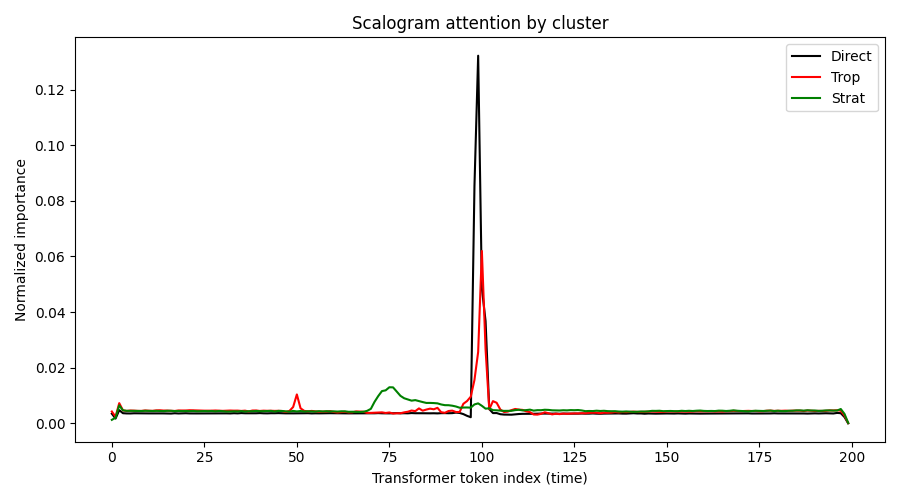

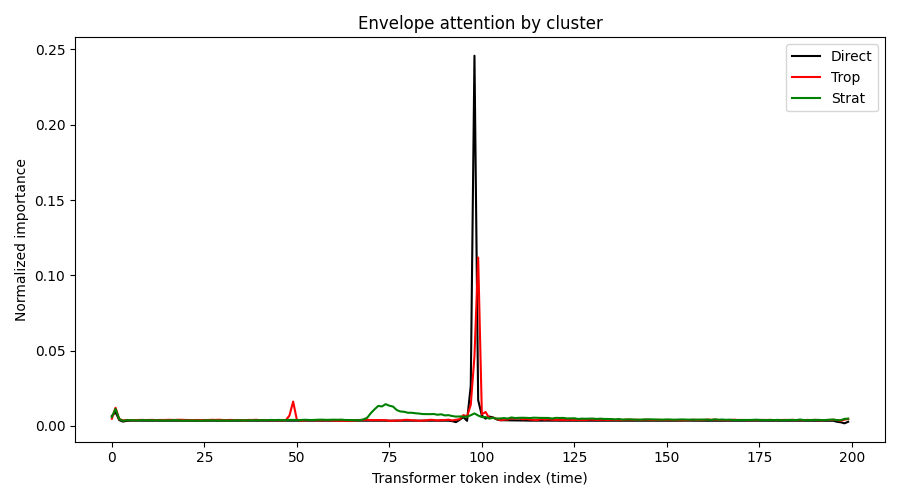

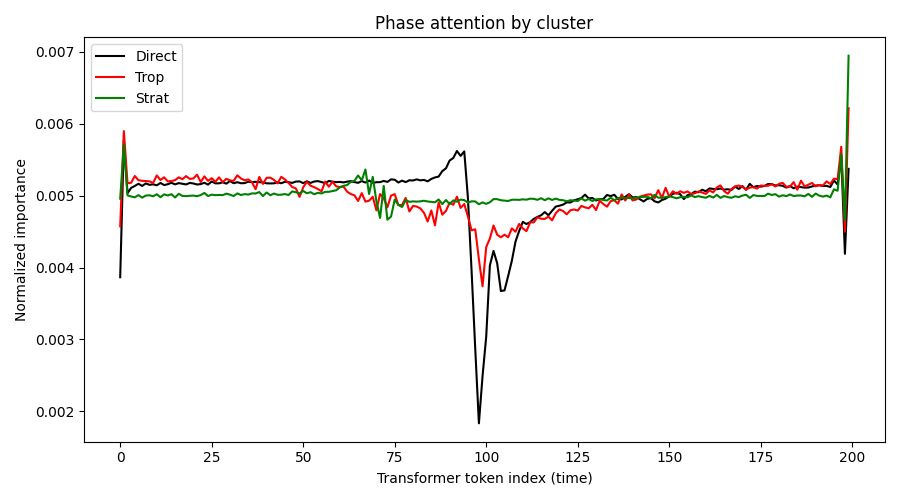

In [30]:
# Plot attention per cluster
def plot_cluster_means(mean_imp, title, labels=None, outpath=None):
    K, T = mean_imp.shape
    t = np.arange(T)
    fig = plt.figure(figsize=(9, 5))
    for k in range(K):
        label = labels[k] if labels is not None else f"Cluster {k}"
        if label == "Direct": color="k"
        elif label == "Trop": color="red"
        elif label == "Strat": color="green"
        plt.plot(t, mean_imp[k], label=label, color=color)
    plt.title(title)
    plt.xlabel("Transformer token index (time)")
    plt.ylabel("Normalized importance")
    plt.legend()
    plt.tight_layout()
    if outpath is not None:
        fig.savefig(outpath, dpi=200, bbox_inches="tight")

phase_labels = ["Direct", "Trop", "Strat"] if np.array_equal(np.unique(y_cluster), [0,1,2]) else None

plot_cluster_means(mean_scal,  "Scalogram attention by cluster", labels=phase_labels, outpath="Scalogram_Attention.png")
plot_cluster_means(mean_env,   "Envelope attention by cluster", labels=phase_labels, outpath="Envelope_Attention.png")
plot_cluster_means(mean_phase, "Phase attention by cluster", labels=phase_labels, outpath="Phase_Attention.png")

In [18]:
%%time
# Now lets quantify how important each modality is to phase assignment
# ---------------------------------------------------------
# 0. Required inputs you must already have
# ---------------------------------------------------------
# X_scalo_crop, X_env_crop, X_sin_crop, X_cos_crop: arrays [N,...]
# y_cluster: length-N cluster labels (GMM or Hungarian-aligned)
# attn_viz_model: model that outputs (scal_attn, env_attn, phase_attn)
# ---------------------------------------------------------

N = X_scalo_crop.shape[0]
K = len(np.unique(y_cluster))     # should be 3
BATCH = 32                        # safe batch size for your GPU

assert len(y_cluster) == N, "Mismatch between samples and labels"

# ---------------------------------------------------------
# 1. Function to convert full attention matrices → token importance
# ---------------------------------------------------------
def to_token_importance(A):
    """
    Input:
        A: [B, H, T, T] (batch, heads, tokens, tokens)
    Output:
        [B, T] token importance curves (L1-normalized)
    """
    A = np.asarray(A)
    A = A.mean(axis=1)             # average over heads → [B, T, T]
    A = A.mean(axis=1)             # average over queries → [B, T]
    denom = np.abs(A).sum(axis=1, keepdims=True) + 1e-12
    return A / denom

# ---------------------------------------------------------
# 2. Accumulators for cluster-wise sums
# ---------------------------------------------------------
sum_scal  = None
sum_env   = None
sum_phase = None
count_per_cluster = np.zeros(K, dtype=int)

# For entropy later
all_scal_tokens  = []
all_env_tokens   = []
all_phase_tokens = []
all_labels       = []

# ---------------------------------------------------------
# 3. Batch inference loop
# ---------------------------------------------------------
for start in range(0, N, BATCH):
    end = min(start + BATCH, N)
    xb = [
        X_scalo_crop[start:end],
        X_env_crop[start:end],
        X_sin_crop[start:end],
        X_cos_crop[start:end],
    ]

    # attn_viz_model returns ONLY attention maps
    scal_attn_b, env_attn_b, phase_attn_b = attn_viz_model.predict(xb, verbose=0)

    # Convert to token importance
    imp_scal_b  = to_token_importance(scal_attn_b)
    imp_env_b   = to_token_importance(env_attn_b)
    imp_phase_b = to_token_importance(phase_attn_b)

    # Save individual tokens for entropy
    all_scal_tokens.append(imp_scal_b)
    all_env_tokens.append(imp_env_b)
    all_phase_tokens.append(imp_phase_b)
    all_labels.append(y_cluster[start:end])

    # Initialize cluster accumulators
    if sum_scal is None:
        T_s = imp_scal_b.shape[1]
        T_e = imp_env_b.shape[1]
        T_p = imp_phase_b.shape[1]
        sum_scal  = np.zeros((K, T_s))
        sum_env   = np.zeros((K, T_e))
        sum_phase = np.zeros((K, T_p))

    # Aggregate per cluster
    y_b = y_cluster[start:end]
    for k in range(K):
        idx = np.where(y_b == k)[0]
        if len(idx) == 0:
            continue
        sum_scal[k]  += imp_scal_b[idx].sum(axis=0)
        sum_env[k]   += imp_env_b[idx].sum(axis=0)
        sum_phase[k] += imp_phase_b[idx].sum(axis=0)
        count_per_cluster[k] += len(idx)

print("Cluster counts:", count_per_cluster)

# ---------------------------------------------------------
# 4. Compute mean token importance per cluster
# ---------------------------------------------------------
mean_scal  = sum_scal  / count_per_cluster[:, None]
mean_env   = sum_env   / count_per_cluster[:, None]
mean_phase = sum_phase / count_per_cluster[:, None]

# ---------------------------------------------------------
# 5. Stack all token-level curves for entropy computation
# ---------------------------------------------------------
all_scal_tokens  = np.concatenate(all_scal_tokens,  axis=0)
all_env_tokens   = np.concatenate(all_env_tokens,   axis=0)
all_phase_tokens = np.concatenate(all_phase_tokens, axis=0)
all_labels       = np.concatenate(all_labels, axis=0)

# ---------------------------------------------------------
# 6. Entropy function
# ---------------------------------------------------------
def attention_entropy(token_curves):
    """
    token_curves: [N, T]
    Returns: [N] entropy per sample
    """
    p = token_curves / (token_curves.sum(axis=1, keepdims=True) + 1e-12)
    return -np.sum(p * np.log(p + 1e-12), axis=1)

# Per-sample entropy
H_scal  = attention_entropy(all_scal_tokens)
H_env   = attention_entropy(all_env_tokens)
H_phase = attention_entropy(all_phase_tokens)

# ---------------------------------------------------------
# 7. Compute mean entropy per cluster
# ---------------------------------------------------------
entropy_results = {}
for k in range(K):
    entropy_results[k] = {
        "scal_entropy":  H_scal[all_labels == k].mean(),
        "env_entropy":   H_env[all_labels == k].mean(),
        "phase_entropy": H_phase[all_labels == k].mean(),
    }

print("\n=== Attention Entropy per Cluster ===")
for k, vals in entropy_results.items():
    print(f"Cluster {k}: {vals}")

# ---------------------------------------------------------
# OUTPUTS YOU NOW HAVE:
# ---------------------------------------------------------
# mean_scal, mean_env, mean_phase → mean attention curves per cluster (for plotting)
# entropy_results → quantitative importance per modality × cluster


Cluster counts: [14015  6860 11660]

=== Attention Entropy per Cluster ===
Cluster 0: {'scal_entropy': np.float32(4.240725), 'env_entropy': np.float32(4.361098), 'phase_entropy': np.float32(5.244223)}
Cluster 1: {'scal_entropy': np.float32(4.364823), 'env_entropy': np.float32(4.313429), 'phase_entropy': np.float32(5.2532315)}
Cluster 2: {'scal_entropy': np.float32(4.3682117), 'env_entropy': np.float32(4.329577), 'phase_entropy': np.float32(5.251076)}
CPU times: user 1min 52s, sys: 27.9 s, total: 2min 20s
Wall time: 2min 11s


2025-11-12 19:57:53.187909: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


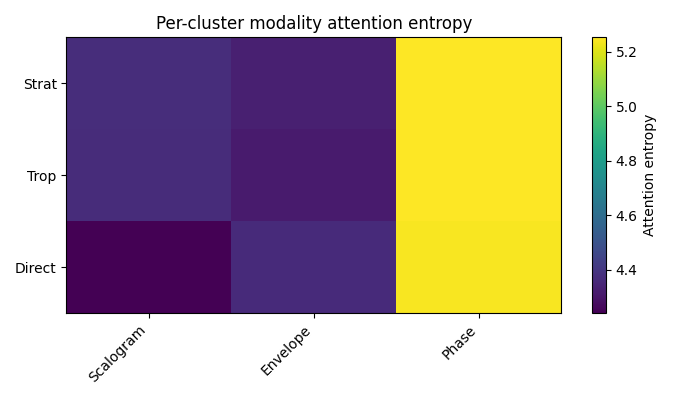

In [31]:
# ---------------------------------------------------------
# 8. Build entropy matrix for pcolormesh
# ---------------------------------------------------------
cluster_names  = ["Direct", "Trop", "Strat"]        # adjust if your mapping differs
modality_names = ["Scalogram", "Envelope", "Phase"]

# Build a K × 3 matrix (clusters × modalities)
H_mat = np.zeros((K, 3), dtype=float)
for k in range(K):
    H_mat[k, 0] = entropy_results[k]["scal_entropy"]
    H_mat[k, 1] = entropy_results[k]["env_entropy"]
    H_mat[k, 2] = entropy_results[k]["phase_entropy"]

# ---------------------------------------------------------
# 9. Plot with pcolormesh
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))

# pcolormesh needs edges, so make a grid
x_edges = np.arange(0, H_mat.shape[1] + 1)   # 0..3
y_edges = np.arange(0, H_mat.shape[0] + 1)   # 0..K

mesh = ax.pcolormesh(x_edges, y_edges, H_mat,
                     cmap="viridis", shading="auto")

# Tick positions at cell centers
ax.set_xticks(np.arange(0.5, H_mat.shape[1] + 0.5))
ax.set_xticklabels(modality_names, rotation=45, ha="right")

ax.set_yticks(np.arange(0.5, H_mat.shape[0] + 0.5))
ax.set_yticklabels(cluster_names)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax)
cbar.set_label("Attention entropy", rotation=90)

ax.set_title("Per-cluster modality attention entropy")
plt.tight_layout()
fig.savefig("Attention_Entropy.png", dpi=200, bbox_inches="tight")